# HW-3

- Subject Name: Deep Learning
- Subject Code: CS 7150
- Professor Name: Jiaji Liu
- Student Name: Varun Guttikonda
- NUID: 002697400

## Question 1

**(2D conv in matrix form)** In the class, we expressed discrete 1d convolution as matrix-vector multiplication, and the matrix is Toeplitz. Here let us consider 2D convolution. We have a $3 \times 3$ image

$$\begin{bmatrix} a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33}\end{bmatrix}$$

and a $2 \times 2$  convolutional kernel/filter,  

$$\begin{bmatrix}b_{11} & b_{12} \\ b_{21} & b_{22}\end{bmatrix}$$

Suppose we use **"valid"** padding, and stride of 1 without any dilation.

### Problem 1
What is the 2D convolution's output?

#### Solution
Usually the output of a 2D convoution is a feature map. The feature map is calculated by sliding the kernel over the input image and performing element-wise multiplication and summing the results. Depending on the strides and dilations, the size of the feature map can be lesser, equal or greater.

To calculate the size of the feature maps, let's make some assumptions:
- $m \times n$ is the height and width of the input image
- $k \times k$ is the height and width of the kernel
- $p$ is the padding
- $s$ is the stride
- $d$ is the dilation

The width of the feature map is given by the formula:
$$W_{out} = \frac{n - k + 2p + (k - 1)(d - 1)}{s} + 1$$

The height of the feature map is given by the formula:
$$H_{out} = \frac{m - k + 2p + (k - 1)(d - 1)}{s} + 1$$

Similarly, the output of the 2D convolution is given by:
$$O(i, j) = \sum_{m}\sum_{n}I(i\cdot s + m\cdot d, j\cdot s + n \cdot d)\cdot K(m,n) + b$$

where:
- $O(i, j)$ is the output at position $(i, j)$
- $I(i\cdot s + m\cdot d, j\cdot s + n \cdot d)$ is the input at position $(i\cdot s + m\cdot d, j\cdot s + n \cdot d)$
- $K(m,n)$ is the kernel at position $(m, n)$
- $b$ is the bias
- $s$ is the stride
- $d$ is the dilation
- $m$ and $n$ are the height and width of the kernel
- $i$ and $j$ are the height and width of the output

### Problem 2
Express the 2D convolution as matrix-vector multiplication.  
(Hint: you are allowed to use the "vectorize" and "reshape" operations. In specific, vectorizing a matrix is simply stacking its columns to form a long vector. Reshaping can convert the long vector back to its matrix format.)

#### Solution
The 2D convolution can be expressed as matrix-vector multiplication by vectorizing the kernel and the input image. The vectorized kernel is a column vector and the vectorized input image is a matrix. The matrix-vector multiplication is then performed to get the feature map.

The vectorized kernel is given by:
$$K_{vec} = \begin{bmatrix}b_{11} \\ b_{21} \\ b_{12} \\ b_{22}\end{bmatrix}$$

The vectorized input image is given by:
$$I_{vec} = \begin{bmatrix}a_{11} \\ a_{21} \\ a_{31} \\ a_{12} \\ a_{22} \\ a_{32} \\ a_{13} \\ a_{23} \\ a_{33}\end{bmatrix}$$

The matrix-vector multiplication is then given by:
$$O_{vec} = I_{vec} \cdot K_{vec}$$

Since the kernel vector is smaller than the input vector, we can slide the kernel vector over the input vector and perform element-wise multiplication and summing the results to get the feature map.

The output feature map is then reshaped to the values given in the previous question.

### Problem 3
Discuss the form of the matrix multiplied to the vector.

#### Solution

The matrix multiplied to the vector is a Toeplitz matrix. A Toeplitz matrix is a matrix in which each descending diagonal from left to right is constant. The matrix is symmetric about the main diagonal. The matrix is given by:

$$T = \begin{bmatrix}a_{11} & a_{12} & a_{13} & 0 & 0 & 0 & 0 & 0 & 0 \\ a_{21} & a_{11} & a_{12} & a_{13} & 0 & 0 & 0 & 0 & 0 \\ a_{31} & a_{21} & a_{11} & a_{12} & a_{13} & 0 & 0 & 0 & 0 \\ 0 & a_{31} & a_{21} & a_{11} & a_{12} & a_{13} & 0 & 0 & 0 \\ 0 & 0 & a_{31} & a_{21} & a_{11} & a_{12} & a_{13} & 0 & 0 \\ 0 & 0 & 0 & a_{31} & a_{21} & a_{11} & a_{12} & a_{13} & 0 \\ 0 & 0 & 0 & 0 & a_{31} & a_{21} & a_{11} & a_{12} & a_{13} \\ 0 & 0 & 0 & 0 & 0 & a_{31} & a_{21} & a_{11} & a_{12} \\ 0 & 0 & 0 & 0 & 0 & 0 & a_{31} & a_{21} & a_{11}\end{bmatrix}$$

The matrix is then multiplied to the vector to get the feature map.

## Question 2
**(Transfer Learning)** In the class, we talked about how to reuse models trained on big datasets, especially when your task doesn't have many training samples. Here we exercise on a task, categorizing 100 classes of sports images. The dataset consists of 13,493 training, 500 validation and 500 test images of size $224 \times 224 \times 3$.  

In [1]:
import os
import pathlib
import random
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
from torch.utils import data
from torchvision import transforms

# Filter warnings
warnings.filterwarnings("ignore")

# Set device for acceleration
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

if DEVICE == "mps":
    torch.mps.empty_cache()
elif DEVICE == "cuda":
    torch.cuda.empty_cache()

print(
    "Using CPU for training and testing as no accelerator is available."
    if DEVICE == "cpu"
    else f"Using {DEVICE} for accleration."
)

# Define DATA_DIR
DATA_DIR = pathlib.Path() / "archive"

# Map label names to integers
folder_names = [*map(lambda x: x[0].split("/")[-1], os.walk(DATA_DIR / "train"))]
folder_names = sorted(folder_names[1:])
labels = dict(enumerate(folder_names))

# Get dataset information
info_df = pd.read_csv(DATA_DIR / "sports.csv")
info_df = info_df[info_df["filepaths"].str.endswith(".jpg")]

train_info = info_df[info_df["data set"] == "train"].drop(
    columns=["data set", "labels"]
)
test_info = info_df[info_df["data set"] == "test"].drop(columns=["data set", "labels"])
val_info = info_df[info_df["data set"] == "valid"].drop(columns=["data set", "labels"])

Using mps for accleration.


In [2]:
# Define transformations
transformation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# Define the dataset class
class SportsDataset(data.Dataset):
    """
    A dataset class for the sports dataset. Reads the data from the csv file and returns the data

    Args:
        location (str): The location of the split folders. This path will be appended with the image name to get the image
        split (str): The split of the dataset. Can be "train", "test", or "val"
    """

    def __init__(self, location, split="train") -> None:
        super().__init__()

        if split not in ["train", "test", "val"]:
            raise ValueError("Invalid split")

        self.split = split
        self.location = location

    def __len__(self) -> int:
        if self.split == "train":
            return 13_492
        elif self.split in ["test", "val"]:
            return 500

    def __getitem__(self, index: int) -> torch.Tensor:
        if self.split == "train":
            img_path = train_info.iloc[index, 1]
            label = train_info.iloc[index, 0]

            img = Image.open(DATA_DIR / img_path)

            if img.mode == "L":
                img = Image.merge("RGB", (img, img, img))

            img = transformation(img)

            return img, label

        elif self.split == "test":
            img_path = test_info.iloc[index, 1]
            label = test_info.iloc[index, 0]

            img = Image.open(DATA_DIR / img_path)

            if img.mode == "L":
                img = Image.merge("RGB", (img, img, img))

            img = transformation(img)

            return img, label

        elif self.split == "val":
            img_path = val_info.iloc[index, 1]
            label = val_info.iloc[index, 0]

            img = Image.open(DATA_DIR / img_path)

            if img.mode == "L":
                img = Image.merge("RGB", (img, img, img))

            img = transformation(img)

            return img, label


# Initialize the datasets
train_dataset = SportsDataset(DATA_DIR, split="train")
test_dataset = SportsDataset(DATA_DIR, split="test")
val_dataset = SportsDataset(DATA_DIR, split="val")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


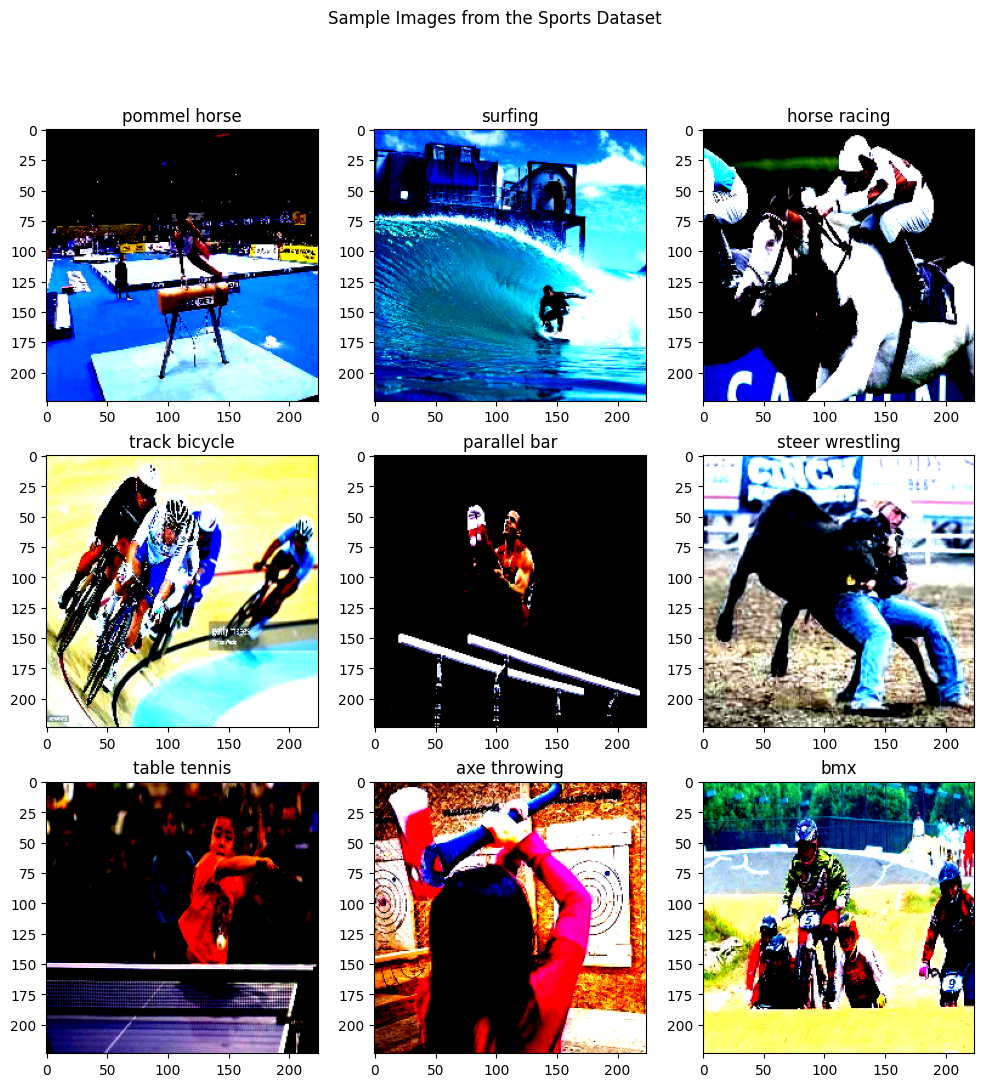

In [3]:
# Generate 9 random indices
indices = random.sample(range(len(train_dataset)), 9)

# Plot the images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Sample Images from the Sports Dataset")
for i, ax in zip(indices, axes.flatten()):
    img, label = train_dataset[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(labels[label])
    ax.axis("on")
plt.show()

In [4]:
HYPERPARAMETERS = {
    "batch_size": 128,
    "shuffle": True,
    "learning_rate": 0.001,
    "momemtum": 0.9,
    "weight_decay": 0.0005,
    "num_classes": 100,
    "epochs": 15,
}

In [5]:
# Define the dataloaders
train_loader = data.DataLoader(
    train_dataset,
    batch_size=HYPERPARAMETERS["batch_size"],
    shuffle=HYPERPARAMETERS["shuffle"],
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=HYPERPARAMETERS["batch_size"],
    shuffle=HYPERPARAMETERS["shuffle"],
)
val_loader = data.DataLoader(
    val_dataset,
    batch_size=HYPERPARAMETERS["batch_size"],
    shuffle=HYPERPARAMETERS["shuffle"],
)

In [6]:
# IMPLEMENT ACCURACY FUNCTION
def accuracy(y_pred, y_true):
    correct_values, total_values = torch.sum(y_pred == y_true), len(y_true)
    accuracy_percentage = correct_values / total_values
    return accuracy_percentage


def train(
    model,
    train_loader,
    criterion,
    optimizer,
    val_loader=None,
    epochs=100,
    device="cpu",
    train_length=None,
    val_length=None,
):
    try:
        _n_batches = len(train_loader)
        _max_char_epoch, _max_char_batch = len(str(epochs)), len(str(_n_batches))

        # BATCH TRAIN FORMAT STRING
        def _batch_train_message(i_epoch, i_batch):
            return f"Epoch {i_epoch:>{_max_char_epoch}}/{epochs} Batch: [{i_batch:>{_max_char_batch}}/{_n_batches}]"

        # CREATE EPOCH TRAIN FORMAT STRING
        def _epoch_train_message(
            i_epoch, i_batch, t_loss, t_accuracy, v_loss=None, v_accuracy=None
        ):
            return (
                f"Epoch {i_epoch:>{_max_char_epoch}}/{epochs} Batch: [{i_batch:>{_max_char_batch}}/{_n_batches}] Train Loss: {t_loss:.4f} Train Accuracy: {t_accuracy:.4f}"
                if v_loss is None or v_accuracy is None
                else f"Epoch {i_epoch:>{_max_char_epoch}}/{epochs} Batch: [{i_batch:>{_max_char_batch}}/{_n_batches}] Train Loss: {t_loss:.4f} Train Accuracy: {t_accuracy:.4f} Val Loss: {v_loss:.4f} Val Accuracy: {v_accuracy:.4f}"
            )

        # Move model to device
        model.to(device)
        print(f"Model moved to {device}\n")

        _train_loss, _val_loss = [], []
        _train_accuracy, _val_accuracy = [], []

        # Train the model
        print("++++++++++ MODEL TRAINING STARTS ++++++++++")

        for epoch in range(1, epochs + 1):
            batch_loss = []

            # Start training
            for batch_idx, (data, labels) in enumerate(train_loader, 1):
                # Set model to train mode
                model.train()

                # Log the batch training
                print(_batch_train_message(epoch, batch_idx), end="\r")

                # Move data and label to device
                data, labels = data.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data)

                loss = criterion(outputs, labels)
                batch_loss.append(loss.item())

                # Backward pass
                loss.backward()
                optimizer.step()

                _train_loss.append(torch.mean(torch.tensor(batch_loss)).item())
                _train_accuracy.append(accuracy(torch.argmax(outputs, dim=1), labels))

                # Remove the tensors from the GPU
                del data, labels, outputs, loss

            if val_loader:
                model.eval()
                with torch.no_grad():
                    _val_batch_loss, _val_batch_accuracy = [], []
                    for data, labels in val_loader:
                        data, labels = data.to(device), labels.to(device)
                        outputs = model(data)
                        _val_batch_loss.append(criterion(outputs, labels).item())
                        _val_batch_accuracy.append(
                            accuracy(torch.argmax(outputs, dim=1), labels)
                        )
                        del data, labels, outputs

                    _val_loss.append(torch.mean(torch.tensor(_val_batch_loss)).item())
                    _val_accuracy.append(
                        torch.mean(torch.tensor(_val_batch_accuracy)).item()
                    )

            print(
                _epoch_train_message(
                    epoch,
                    batch_idx,
                    _train_loss[-1],
                    _train_accuracy[-1],
                    _val_loss[-1] if val_loader else None,
                    _val_accuracy[-1] if val_loader else None,
                )
            )

        print("\n++++++++++ MODEL TRAINING ENDS ++++++++++")

        return {
            "epoch_train_loss": _train_loss,
            "epoch_val_loss": _val_loss,
            "epoch_train_accuracy": _train_accuracy,
            "epoch_val_accuracy": _val_accuracy,
            "train_loss": torch.mean(torch.tensor(_train_loss)).item(),
            "val_loss": torch.mean(torch.tensor(_val_loss)).item(),
            "train_accuracy": torch.mean(torch.tensor(_train_accuracy)).item(),
            "val_accuracy": torch.mean(torch.tensor(_val_accuracy)).item(),
        }

    except RuntimeError as re:
        print("++++++++++ MODEL TRAINING ENDS ++++++++++")
        print("Some error occurred. Training stopped.")
        print(re)
        return
    except KeyboardInterrupt:
        print("\n")
        print("++++++++++ MODEL TRAINING ENDS ++++++++++")
        print("Training interrupted.")


def test(model, test_loader, criterion, device="cpu"):
    model.to(device)

    _n_test_batches = len(test_loader)
    _max_char_batch = len(str(_n_test_batches))

    _test_accuracy, _test_loss = [], []

    for batch_idx, (data, labels) in enumerate(test_loader, 1):
        # Set model to eval mode
        model.eval()

        # Log the batch testing
        print(f"Batch: [{batch_idx:>{_max_char_batch}}/{_n_test_batches}]", end="\r")

        # Move data and label to device
        data, labels = data.to(device), labels.to(device)

        # Forward pass
        outputs = model(data)

        _test_loss.append(criterion(outputs, labels).item())
        _test_accuracy.append(accuracy(torch.argmax(outputs, dim=1), labels))

    # Finally move model back to CPU so that other models can use the GPU
    model.to("cpu")

    return {
        "test_loss": torch.mean(torch.tensor(_test_loss)).item(),
        "test_accuracy": torch.mean(torch.tensor(_test_accuracy)).item(),
    }

In [7]:
class AlexNet(torch.nn.Module):
    def __init__(self, base_model, layers=[]):
        super(AlexNet, self).__init__()
        self.base_model = base_model
        self.final_layer = torch.nn.Sequential(*layers)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(self.final_layer(self.base_model(x)))

### Problem 1
Train our own AlexNet from scratch without refering to any weights published. Report the test accuracy

In [8]:
plain_alexnet = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "alexnet",
    weights=None,
    num_classes=HYPERPARAMETERS["num_classes"],
)

saved_path = pathlib.Path() / "no_weights_alexnet.pth"

no_weights_alexnet = (
    AlexNet(plain_alexnet) if not saved_path.exists() else torch.load(saved_path)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    no_weights_alexnet.parameters(),
    lr=HYPERPARAMETERS["learning_rate"],
    momentum=HYPERPARAMETERS["momemtum"],
    weight_decay=HYPERPARAMETERS["weight_decay"],
)

Using cache found in /Users/varunguttikonda/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
if not saved_path.exists():
    print("No saved model found. Training the model now.")
    p1_history = train(
        model=no_weights_alexnet,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        val_loader=val_loader,
        epochs=HYPERPARAMETERS["epochs"],
        device=DEVICE,
    )
    torch.save(no_weights_alexnet, saved_path)

p1_test_results = test(
    model=no_weights_alexnet,
    test_loader=test_loader,
    criterion=criterion,
    device=DEVICE,
)

### Problem 2
Reuse the weights from AlexNet, design a transfer learning strategy and report the test accuracy. Compare and discuss with the result you get for Problem 1.

In [10]:
trained_alexnet = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "alexnet",
    weights=True,
    num_classes=1000,
)

saved_path = pathlib.Path() / "weights_alexnet.pth"

weights_alexnet = (
    AlexNet(trained_alexnet) if not saved_path.exists() else torch.load(saved_path)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    weights_alexnet.parameters(),
    lr=HYPERPARAMETERS["learning_rate"],
    momentum=HYPERPARAMETERS["momemtum"],
    weight_decay=HYPERPARAMETERS["weight_decay"],
)

Using cache found in /Users/varunguttikonda/.cache/torch/hub/pytorch_vision_v0.10.0


In [11]:
if not saved_path.exists():
    p2_history = train(
        model=weights_alexnet,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        val_loader=val_loader,
        epochs=HYPERPARAMETERS["epochs"],
        device=DEVICE,
    )
    torch.save(weights_alexnet, saved_path)

p2_test_results = test(
    model=weights_alexnet,
    test_loader=test_loader,
    criterion=criterion,
    device=DEVICE,
)

### Problem 3
If you are allowed to use multiple existing models e.g.., vgg19, resnet50 and inception, design a transfer learning strategy and report the test accuracy. Compare and discuss with the result you get for Problem 1 and Problem 2.

In [12]:
vgg_model = torch.hub.load("pytorch/vision:v0.10.0", "vgg11", pretrained=False)
resnet50 = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub", "nvidia_resnet50", pretrained=True
)
inception_model = torch.hub.load("pytorch/vision:v0.10.0", "googlenet", pretrained=True)

Using cache found in /Users/varunguttikonda/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/varunguttikonda/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /Users/varunguttikonda/.cache/torch/hub/pytorch_vision_v0.10.0


In [13]:
saved_path = pathlib.Path() / "vgg_model.pth"

vgg_model = (
    AlexNet(vgg_model, layers=[torch.nn.Linear(1000, 100)])
    if not saved_path.exists()
    else torch.load(saved_path)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    vgg_model.parameters(),
    lr=HYPERPARAMETERS["learning_rate"],
    momentum=HYPERPARAMETERS["momemtum"],
    weight_decay=HYPERPARAMETERS["weight_decay"],
)

if not saved_path.exists():
    vgg_history = train(
        model=vgg_model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        val_loader=val_loader,
        epochs=HYPERPARAMETERS["epochs"],
        device=DEVICE,
    )
    torch.save(vgg_model, saved_path)

vgg_test_results = test(
    model=vgg_model,
    test_loader=test_loader,
    criterion=criterion,
    device=DEVICE,
)

In [14]:
# saved_path = pathlib.Path() / "resnet.pth"

# resnet_model = (
#     AlexNet(resnet50, layers=[torch.nn.Linear(1000, 100)])
#     if not saved_path.exists()
#     else torch.load(saved_path)
# )

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(
#     resnet_model.parameters(),
#     lr=HYPERPARAMETERS["learning_rate"],
#     momentum=HYPERPARAMETERS["momemtum"],
#     weight_decay=HYPERPARAMETERS["weight_decay"],
# )

# if not saved_path.exists():
#     resnet_history = train(
#         model=resnet_model,
#         train_loader=train_loader,
#         criterion=criterion,
#         optimizer=optimizer,
#         val_loader=val_loader,
#         epochs=HYPERPARAMETERS["epochs"],
#         device=DEVICE,
#     )
#     torch.save(resnet_model, saved_path)

# resnet_test_results = test(
#     model=resnet_model,
#     test_loader=test_loader,
#     criterion=criterion,
#     device=DEVICE,
# )

In [15]:
saved_path = pathlib.Path() / "inception.pth"

inception_model = (
    AlexNet(inception_model, layers=[torch.nn.Linear(1000, 100)])
    if not saved_path.exists()
    else torch.load(saved_path)
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    inception_model.parameters(),
    lr=HYPERPARAMETERS["learning_rate"],
    momentum=HYPERPARAMETERS["momemtum"],
    weight_decay=HYPERPARAMETERS["weight_decay"],
)

if not saved_path.exists():
    inception_history = train(
        model=inception_model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        val_loader=val_loader,
        epochs=HYPERPARAMETERS["epochs"],
        device=DEVICE,
    )
    torch.save(inception_model, saved_path)

inception_test_results = test(
    model=inception_model,
    test_loader=test_loader,
    criterion=criterion,
    device=DEVICE,
)

In [16]:
# Create a dataframe for the results
data = {
    "No Weights AlexNet": [
        p1_test_results["test_loss"],
        p1_test_results["test_accuracy"],
    ],
    "Weights AlexNet": [
        p2_test_results["test_loss"],
        p2_test_results["test_accuracy"],
    ],
    "VGG11": [vgg_test_results["test_loss"], vgg_test_results["test_accuracy"]],
    # "ResNet50": [resnet_test_results["test_loss"], resnet_test_results["test_accuracy"]],
    "Inception": [
        inception_test_results["test_loss"],
        inception_test_results["test_accuracy"],
    ],
}

df = pd.DataFrame(
    data,
    index=["Test Loss", "Test Accuracy"],
)

df = df.T.sort_values(by="Test Accuracy", ascending=False)
df

,Test Loss,Test Accuracy
Inception,4.503082,0.144666
Weights AlexNet,6.801510,0.112204
No Weights AlexNet,4.605170,0.012123
VGG11,4.605149,0.007812


## Findings
- ResNet50 is a very large model and training is very slow despite using MPS accelration.
- I would use the InceptionNet as it has the best accuracy and is faster to train than ResNet50.
- The accuracy of the transfer learning model is better than the model trained from scratch.
- Always train the model for convergence. Here I have trained the models for 15 epochs while the model can be trained for 100 epochs for better accuracy.

## Footer
- Data Source: [https://www.kaggle.com/datasets/gpiosenka/sports-classification/code](https://www.kaggle.com/datasets/gpiosenka/sports-classification/code)
- AlexNet model: [https://pytorch.org/hub/pytorch_vision_alexnet/](https://pytorch.org/hub/pytorch_vision_alexnet/)
- VGG19 model: [https://pytorch.org/hub/pytorch_vision_vgg/](https://pytorch.org/hub/pytorch_vision_vgg/)
- Resnet50 model: [https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/](https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/)
- InceptionNet model: [https://pytorch.org/hub/pytorch_vision_googlenet/](https://pytorch.org/hub/pytorch_vision_googlenet/)